<a href="https://colab.research.google.com/github/alcarvalhox/Projeto-Eddy-Current/blob/master/MiniVGGNet_Eddy_Current_artigo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

INICIO
[INFO] loading images...
Imagens Carregadas
imagens redimensionadas
Imagens tranformadas em matrizes
Processa as imagens
[INFO] processed 500/2846
[INFO] processed 1000/2846
[INFO] processed 1500/2846
[INFO] processed 2000/2846
[INFO] processed 2500/2846
Imagens normalizadas
Imagens divididas treino e teste
Labels convertidos para vetores
[INFO] compiling model...
[INFO] training network...


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/50
67/67 [==============================] - 15s 183ms/step - loss: 1.3450 - accuracy: 0.5074 - val_loss: 1.2639 - val_accuracy: 0.3188
Epoch 2/50
67/67 [==============================] - 11s 171ms/step - loss: 0.6651 - accuracy: 0.7516 - val_loss: 1.7158 - val_accuracy: 0.3188
Epoch 3/50
67/67 [==============================] - 11s 172ms/step - loss: 0.4998 - accuracy: 0.7931 - val_loss: 1.7414 - val_accuracy: 0.3188
Epoch 4/50
67/67 [==============================] - 12s 172ms/step - loss: 0.3888 - accuracy: 0.8485 - val_loss: 1.5656 - val_accuracy: 0.3188
Epoch 5/50
67/67 [==============================] - 12s 173ms/step - loss: 0.3851 - accuracy: 0.8496 - val_loss: 1.6286 - val_accuracy: 0.3188
Epoch 6/50
67/67 [==============================] - 12s 173ms/step - loss: 0.3119 - accuracy: 0.8835 - val_loss: 1.5915 - val_accuracy: 0.3413
Epoch 7/50
67/67 [==============================] - 11s 172ms/step - loss: 0.2976 - accuracy: 0.8883 - val_loss: 0.4691 - val_accuracy: 0.7949

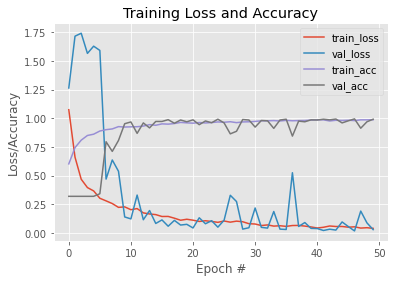

[INFO] sampling images...
[INFO] loading pre-trained network...
[INFO] predicting...


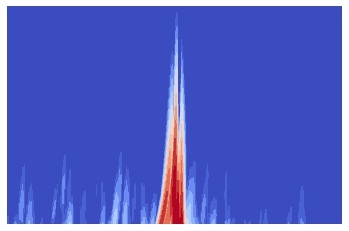

Junta


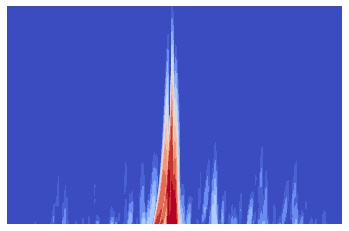

Junta


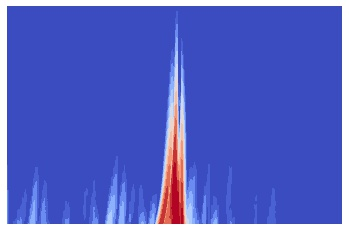

Junta


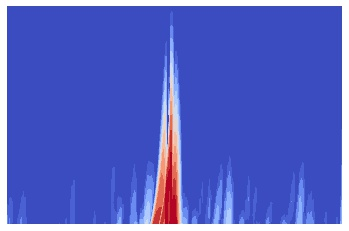

Junta


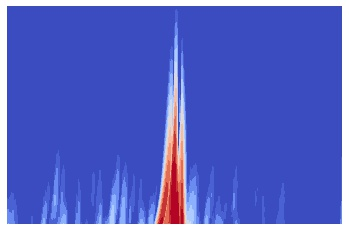

Junta


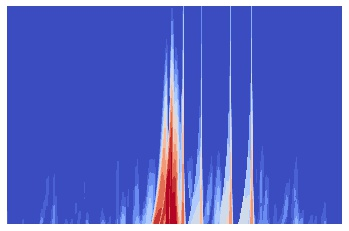

Junta


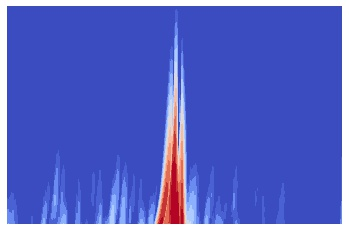

Junta


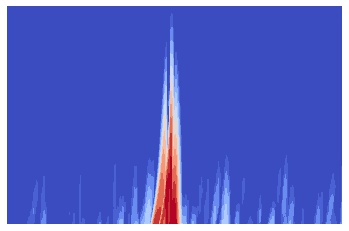

Junta


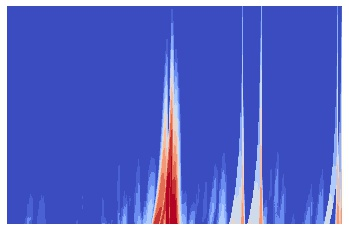

Junta


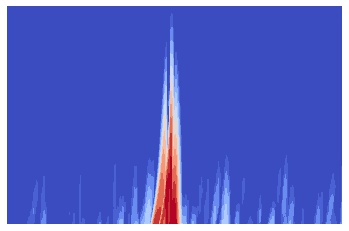

Junta


In [8]:
# import the necessary packages
%matplotlib inline 
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
#from pyimagesearch.preprocessing import ImageToArrayPreprocessor
#from pyimagesearch.preprocessing import SimplePreprocessor
#from pyimagesearch.datasets import SimpleDatasetLoader
#from pyimagesearch.nn.conv import ShallowNet
from imutils import paths
#import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2 
import os 
from keras.preprocessing.image import img_to_array
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K
from keras.utils.vis_utils import plot_model
#from keras.utils import plot_model
from keras.models import load_model
import matplotlib 
matplotlib.use("Agg")
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.image as mpimg 
from matplotlib.pyplot import imshow
import pylab as pl
from google.colab import files
from google.colab.patches import cv2_imshow
from IPython.display import Image, display
#!pip install -U ggplot
#!pip install ggplot 
#from ggplot import *
#import ggplot as ggplot


############################
# Transforma Imagem em array
############################
class ImageToArrayPreprocessor:
	def __init__(self, dataFormat=None):
		# store the image data format
		self.dataFormat = dataFormat

	def preprocess(self, image):
		# apply the Keras utility function that correctly rearranges
		# the dimensions of the image
		return img_to_array(image, data_format=self.dataFormat)

####################################################
# Faz o preprocessamento de imagens largura x altura
####################################################
class SimplePreprocessor:
	def __init__(self, width, height, inter=cv2.INTER_AREA):
		# store the target image width, height, and interpolation
		# method used when resizing
		self.width = width
		self.height = height
		self.inter = inter

	def preprocess(self, image):
		# resize the image to a fixed size, ignoring the aspect
		# ratio
		return cv2.resize(image, (self.width, self.height),
			interpolation=self.inter)
  
###################################
# Carrega os dados e cria os labels
###################################
class SimpleDatasetLoader:
	def __init__(self, preprocessors=None):
		# store the image preprocessor
		self.preprocessors = preprocessors

		# if the preprocessors are None, initialize them as an
		# empty list
		if self.preprocessors is None:
			self.preprocessors = []

	def load(self, imagePaths, verbose=-1):
		# initialize the list of features and labels
		data = []
		labels = []

		# loop over the input images
		for (i, imagePath) in enumerate(imagePaths):
			# load the image and extract the class label assuming
			# that our path has the following format:
			# /path/to/dataset/{class}/{image}.jpg
			image = cv2.imread(imagePath)
			label = imagePath.split(os.path.sep)[-2]

			# check to see if our preprocessors are not None
			if self.preprocessors is not None:
				# loop over the preprocessors and apply each to
				# the image
				for p in self.preprocessors:
					image = p.preprocess(image)

			# treat our processed image as a "feature vector"
			# by updating the data list followed by the labels
			data.append(image)
			labels.append(label)

			# show an update every `verbose` images
			if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
				print("[INFO] processed {}/{}".format(i + 1,
					len(imagePaths)))

		# return a tuple of the data and labels
		return (np.array(data), np.array(labels))
  

############
# MiniVGGNet
############
class MiniVGGNet:
	@staticmethod
	def build(width, height, depth, classes):
		# initialize the model along with the input shape to be
		# "channels last" and the channels dimension itself
		model = Sequential()
		inputShape = (height, width, depth)
		chanDim = -1

		# if we are using "channels first", update the input shape
		# and channels dimension
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)
			chanDim = 1

		# first CONV => RELU => CONV => RELU => POOL layer set
		model.add(Conv2D(32, (3, 3), padding="same",
			input_shape=inputShape))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(32, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))

		# second CONV => RELU => CONV => RELU => POOL layer set
		model.add(Conv2D(32, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(32, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))

		# first (and only) set of FC => RELU layers
		model.add(Flatten())
		model.add(Dense(512))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))

		# softmax classifier
		model.add(Dense(classes))
		model.add(Activation("softmax"))

		# return the constructed network architecture
		return model


# construct the argument parse and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-d", "--dataset", required=True,
#	help="path to input dataset")
#ap.add_argument("-m", "--model", required=True,
#	help="path to output model")
#args = vars(ap.parse_args())

# Variáveis de entrada

print('INICIO')

#path = "/content/drive/My Drive/Profissoes/idenprof/train"
#path = "/content/drive/My Drive/Projeto Eddy Current/ProjetoFinal/Amostras"
path = '/content/drive/MyDrive/Projetos/Projeto Eddy Current/ProjetoFinal/Amostras'
#target_names=["chef", "doctor", "engineer","farmer","firefighter","judge","mechanic","pilot","police","waiter"]
target_names=["Junta", "Solda","Squat"]

# grab the list of images that we'll be describing
print("[INFO] loading images...")
#imagePaths = list(paths.list_images(args["dataset"]))
imagePaths = list(paths.list_images(path))

print('Imagens Carregadas')

# initialize the image preprocessors
sp = SimplePreprocessor(32, 32)
#sp = SimplePreprocessor(64, 64)
print('imagens redimensionadas')

iap = ImageToArrayPreprocessor()
print('Imagens tranformadas em matrizes')
# load the dataset from disk then scale the raw pixel intensities
# to the range [0, 1]
sdl = SimpleDatasetLoader(preprocessors=[sp, iap])
print('Processa as imagens')
(data, labels) = sdl.load(imagePaths, verbose=500)
data = data.astype("float") / 255.0
print('Imagens normalizadas')

# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.25, random_state=42)
print('Imagens divididas treino e teste')
# convert the labels from integers to vectors
trainY = LabelBinarizer().fit_transform(trainY)
testY = LabelBinarizer().fit_transform(testY)
print('Labels convertidos para vetores')
# initialize the optimizer and model
print("[INFO] compiling model...")
opt = SGD(lr=0.005)
model = MiniVGGNet.build(width=32, height=32, depth=3, classes=3)
#binary_crossentropy
#categorical_crossentropy
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the network
print("[INFO] training network...")
H = model.fit(trainX, trainY, validation_data=(testX, testY),
	batch_size=32, epochs=50, verbose=1)

# save the network to disk
#path_modelo = "/content/drive/My Drive/idenprof/idenprof/models/weights.hdf5"
#path_modelo = "/content/drive/My Drive/Projeto Eddy Current/ProjetoFinal/modelo/4classes100E.hdf5"
path_modelo = "/content/drive/My Drive/Projeto Eddy Current/ProjetoFinal/modelo/3classes40E_art.hdf5"
print("[INFO] serializing network...")
model.save(path_modelo)

# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1),
	target_names=["Junta", "Solda","Squat"]))
	#target_names=["chef", "doctor", "engineer","farmer","firefighter","judge","mechanic","pilot","police","waiter"]))

# plot the training loss and accuracy
#plt.style.use('classic')

epocas = 50
%matplotlib inline
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epocas), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, epocas), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, epocas), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, epocas), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()


#################################
# Faz a validação do modelo #####
#################################


# construct the argument parse and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-d", "--dataset", required=True,
#	help="path to input dataset")
#ap.add_argument("-m", "--model", required=True,
#	help="path to pre-trained model")
#args = vars(ap.parse_args())

# initialize the class labels

#classLabels = ["chef", "doctor", "engineer","farmer","firefighter","judge","mechanic","pilot","police","waiter"]
classLabels = ["Junta", "Solda","Squat"]


# grab the list of images in the dataset then randomly sample
# indexes into the image paths list
#path_imagens = "/content/drive/My Drive/idenprof/idenprof/validacao"
print("[INFO] sampling images...")
#imagePaths = np.array(list(paths.list_images("/content/drive/My Drive/idenprof/idenprof/validacao")))
#imagePaths = np.array(list(paths.list_images("/content/drive/My Drive/Projeto Eddy Current/ProjetoFinal/t_wavelet")))
imagePaths = np.array(list(paths.list_images("/content/drive/MyDrive/Projetos/Projeto Eddy Current/ProjetoFinal/t_wavelet")))
idxs = np.random.randint(0, len(imagePaths), size=(10,))
#idxs = np.random.randint(0, len(imagePaths), size=(2,))
imagePaths = imagePaths[idxs]


# initialize the image preprocessors
sp = SimplePreprocessor(32, 32)
iap = ImageToArrayPreprocessor()

# load the dataset from disk then scale the raw pixel intensities
# to the range [0, 1]
sdl = SimpleDatasetLoader(preprocessors=[sp, iap])
(data, labels) = sdl.load(imagePaths)
data = data.astype("float") / 255.0

# load the pre-trained network
#path_modelo = "/content/drive/My Drive/idenprof/idenprof/models/weights.hdf5"
#path_modelo = "/content/drive/My Drive/Projeto Eddy Current/ProjetoFinal/modelo/4classes100E.hdf5"
path_modelo = "/content/drive/My Drive/Projeto Eddy Current/ProjetoFinal/modelo/3classes40E_art.hdf5"
#path_modelo = "/content/drive/My Drive/Projeto Eddy Current/Supervisionado/Figuras_Python_CNN/modelo/weights50_2.hdf5"
print("[INFO] loading pre-trained network...")
model = load_model(path_modelo)

# make predictions on the images
print("[INFO] predicting...")
preds = model.predict(data, batch_size=32).argmax(axis=1)



# loop over the sample images
for (i, imagePath) in enumerate(imagePaths):
	#image = cv2.imread(imagePaths)
  #cv2.putText(image, classLabels[preds[i]], (10,30),cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
  #image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
	#plt.figure()
  #plt.title("chef")
  #plt.imshow(image)
  #plt.colorbar()
  #plt.grid(False)
  display(Image(imagePath))
  print(classLabels[preds[i]])
  




# **Accuracy Score**

In [9]:
#pred = model.predict(x_test)
pred = model.predict(testX, batch_size=32)
pred = np.argmax(pred,axis=1) 
# raw probabilities to chosen class (highest probability)

from sklearn import metrics

y_compare = np.argmax(testY,axis=1) 
score = metrics.accuracy_score(y_compare, pred)
print("Accuracy score: {}".format(score))

Accuracy score: 0.9915730337078652


# **Confusion Matrix**

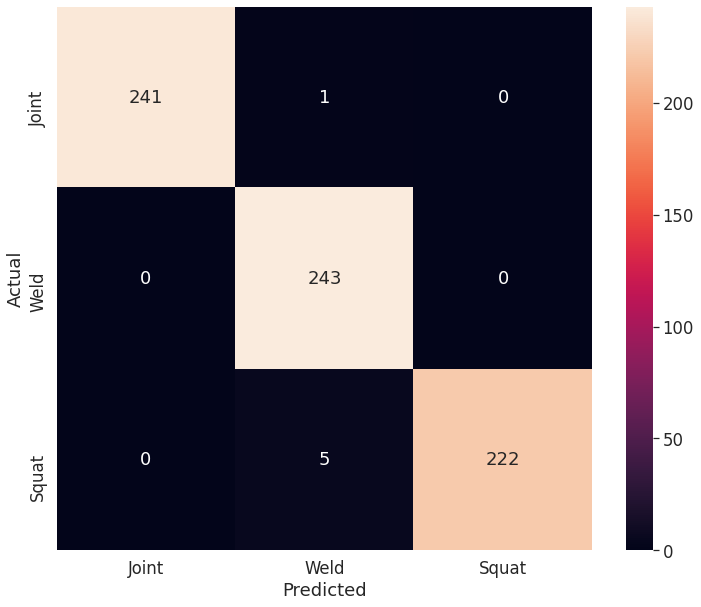

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
confusion_matrix(y_compare,pred)
cf_matrix = confusion_matrix(y_compare, pred)
#print(cf_matrix)
classes = ["Joint", "Weld","Squat"]
plt.figure(figsize = (12,10))
sns.set (font_scale = 1.5)
sns.heatmap(cf_matrix, annot=True, fmt='d',xticklabels=classes, yticklabels=classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
#sns.heatmap(cf_matrix, annot=True)
sns.set (font_scale = 0.8)

name = 'CNN'
#cmatrix=sns.heatmap(cf_matrix,annot=True,fmt='d')
figure = cf_matrix.get_figure() 
nome_da_figura = '/content/drive/MyDrive/Projeto Eddy Current/Artigo/'+name+'_cmatrix.pdf'   
figure.savefig(nome_da_figura, dpi=400)


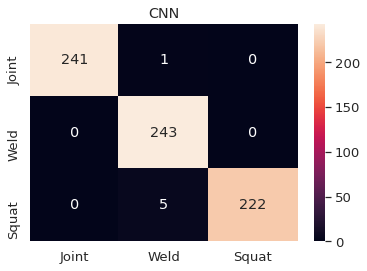

In [13]:
 #(cm)= evaluate_model(X_train, y_train, model,name) 
 sns.set(font_scale=1.2)
 plt.figure(figsize=(6,4))
 name = 'CNN'
 plt.title(name)
 #df_cm = pd.DataFrame(cm, index=classes, columns=classes)
 cmatrix=sns.heatmap(cf_matrix, annot=True, fmt='d',xticklabels=classes, yticklabels=classes)
 figure = cmatrix.get_figure() 
 nome_da_figura = '/content/drive/MyDrive/Projeto Eddy Current/Artigo/'+name+'_cmatrix.pdf'   
 figure.savefig(nome_da_figura, dpi=400)

[[122   0   1   1]
 [  0 282   6   1]
 [  0   0 229   1]
 [ 10   0  26 154]]


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


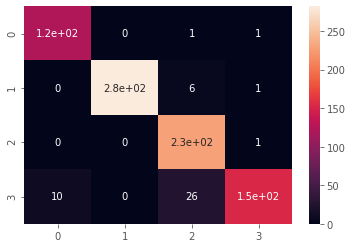

In [ ]:
cf_matrix = confusion_matrix(y_compare, pred)
print(cf_matrix)
import seaborn as sns
sns.heatmap(cf_matrix, annot=True)

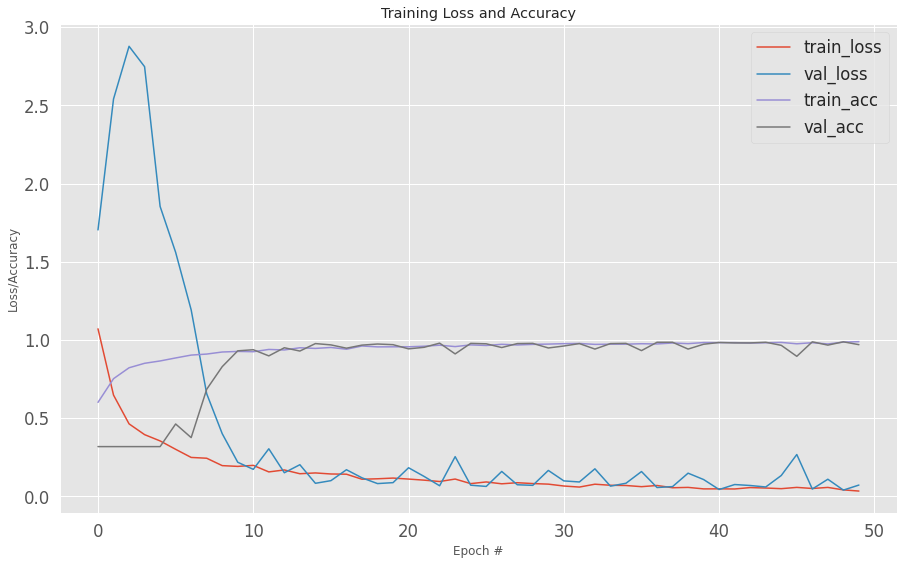

In [ ]:

# plotar loss e accuracy para os datasets 'train' e 'test'
sns.set (font_scale = 1.5)
plt.style.use("ggplot")
plt.figure(figsize = (15,9))
plt.plot(np.arange(0,epocas), H.history["loss"], label="train_loss")
plt.plot(np.arange(0,epocas), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,epocas), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0,epocas), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('cnn.png', bbox_inches='tight')


# **Plotar loss e accuracy para os datasets 'train' e 'test'**

# **Resumo do Modelo**

In [ ]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)       

# **Estrutura do Modelo**

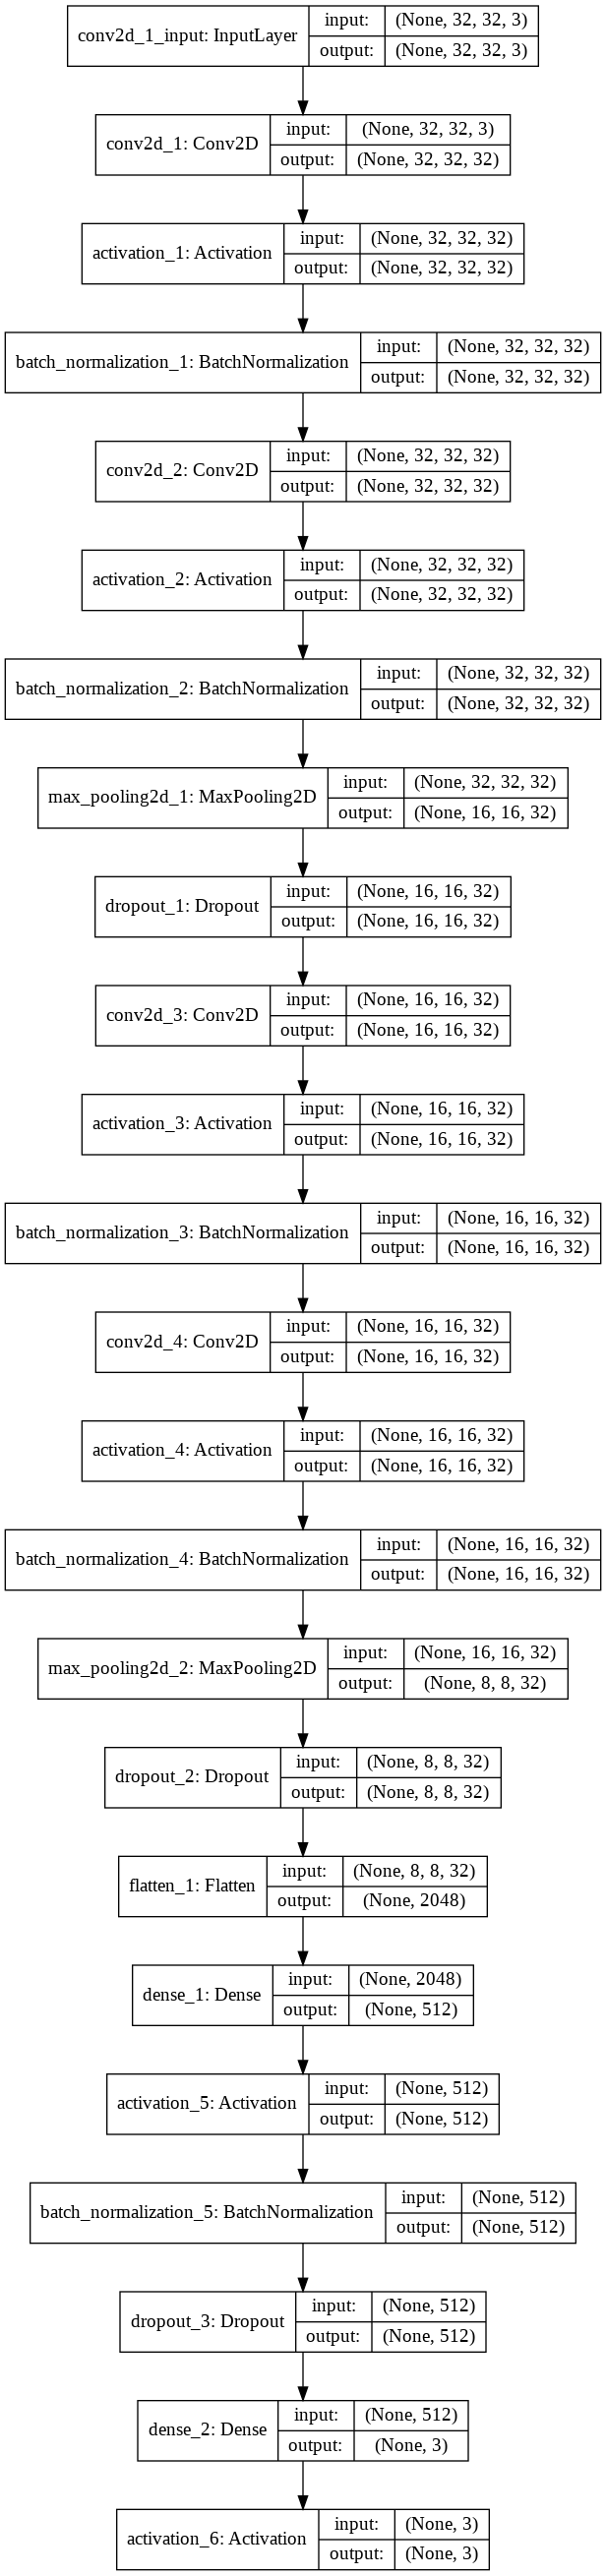

In [ ]:
plot_model(model, to_file='/content/drive/My Drive/Projeto Eddy Current/Supervisionado/Artigos/model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
from IPython.display import display

# Don't display numpy in scientific notation
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

# Generate predictions
#pred = model.predict(x_test)
pred = model.predict(testX, batch_size=32)

print("Numpy array of predictions")
display(pred[0:5])

print("As percent probability")
print(pred[0]*100)

score = metrics.log_loss(testY, pred)
print("Log loss score: {}".format(score))

# raw probabilities to chosen class (highest probability)
pred = np.argmax(pred,axis=1)

Numpy array of predictions


array([[0.0706, 0.9134, 0.0136, 0.0024],
       [0.004 , 0.0001, 0.018 , 0.9779],
       [0.0027, 0.9972, 0.    , 0.    ],
       [0.2929, 0.    , 0.0177, 0.6893],
       [0.0007, 0.    , 0.9989, 0.0004]], dtype=float32)

As percent probability
[ 7.0633 91.3365  1.3645  0.2356]
Log loss score: 0.13425864578751634


In [ ]:
import seaborn
import matplotlib.pyplot as plt
 
 
def plot_confusion_matrix(data, labels, output_filename):
    """Plot confusion matrix using heatmap.
 
    Args:
        data (list of list): List of lists with confusion matrix data.
        labels (list): Labels which will be plotted across x and y axis.
        output_filename (str): Path to output file.
 
    """
    seaborn.set(color_codes=True)
    plt.figure(1, figsize=(9, 6))
 
    plt.title("Matriz Confusão")
 
    seaborn.set(font_scale=1.4)
    ax = seaborn.heatmap(data, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Scale'})
    #ax = seaborn.heatmap(data/np.sum(data), annot=True,fmt='.2%', cmap='Blues',cbar_kws={'label': 'Scale'})
    #ax = sns.heatmap(data/np.sum(data), annot=True,fmt='.2%', cmap='Blues',cbar_kws={'label': 'Scale'})
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
 
    ax.set(ylabel="Imagens Reais", xlabel="Imagens Previstas")
 
    plt.savefig(output_filename, bbox_inches='tight', dpi=300)
    plt.show
    plt.close()
 

data = confusion_matrix(y_compare, pred)        
 
# define labels
labels = ["Cracking", "Junta", "Solda","Squat"]
 
# create confusion matrix
plot_confusion_matrix(data, labels, "/content/drive/My Drive/Projeto Eddy Current/Supervisionado/Artigos/confusion_matrix2porttot4classes.png")

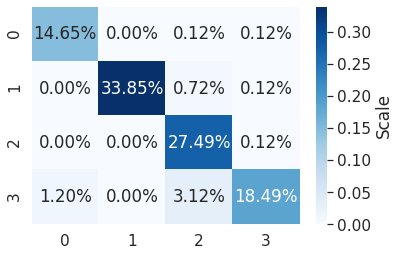

In [ ]:
#sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
 #           fmt='.2%', cmap='Blues')

sns.heatmap(data/np.sum(data), annot=True,fmt='.2%', cmap='Blues',cbar_kws={'label': 'Scale'})

In [ ]:
#importing a 3-class dataset from sklearn's toy dataset
#from sklearn.datasets import load_wine

#dataset = load_wine()
#X = dataset.data
#y = dataset.target
#from sklearn.model_selection import train_test_split
#from sklearn.svm import SVC

#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
#svc = SVC(kernel='rbf', C=1).fit(X_train, y_train)
#y_pred = svc.predict(X_test)

#importing confusion matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_compare, pred)
print('Confusion Matrix\n')
print(confusion)

#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_compare, pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_compare,pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_compare, pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_compare, pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_compare, pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_compare, pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_compare, pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_compare, pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_compare, pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_compare, pred, average='weighted')))

from sklearn.metrics import classification_report
print('\nRelatório de Classificação\n')
print(classification_report(y_compare, pred, target_names=['Junta Isolada', 'Junta seca', 'Solda']))


Confusion Matrix

[[122   0   1   1]
 [  0 282   6   1]
 [  0   0 229   1]
 [ 10   0  26 154]]

Accuracy: 0.94

Micro Precision: 0.94
Micro Recall: 0.94
Micro F1-score: 0.94

Macro Precision: 0.94
Macro Recall: 0.94
Macro F1-score: 0.94

Weighted Precision: 0.95
Weighted Recall: 0.94
Weighted F1-score: 0.94

Relatório de Classificação



ValueError: ignored

In [ ]:
y_compare0 = [] # Junta Isolada x Junta Seca
pred0 = []# Junta Isolada x Junta Seca

y_compare1 = [] # Junta Isolada x Solda
pred1 = []# Junta Isolada x Solda

y_compare2 = [] # Junta Seca x Solda
pred2 = []# Junta Seca x Solda

for i in range(0,y_compare.shape[0]):
   if y_compare[i] == 0 or y_compare[i] == 1:
     y_compare0.append(y_compare[i])
     pred0.append(pred[i])
 
for i in range(0,y_compare.shape[0]):
   if y_compare[i] == 0 or y_compare[i] == 2:
     y_compare1.append(y_compare[i]/2)
     pred1.append(pred[i]/2)


for i in range(0,y_compare.shape[0]):
   
   if y_compare[i] == 1 and pred[i] > 0:
     y_compare2.append(y_compare[i]-1)
     if pred[i] == 1:
       pred2.append(pred[i]-1)  
     if pred[i] == 2:
       pred2.append(pred[i]/2)
   if y_compare[i] == 2 and pred[i] > 0:
     y_compare2.append(y_compare[i]/2)
     if pred[i] == 1:
       pred2.append(pred[i]-1)  
     if pred[i] == 2:
       pred2.append(pred[i]/2)






In [ ]:
len(pred2)

582

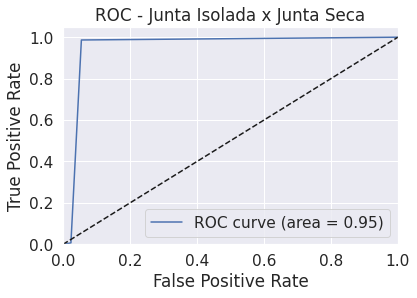

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', 
                            cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, _ = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC - Junta Isolada x Junta Seca')
    plt.legend(loc="lower right")
    plt.show()

#pred = model.predict(x_test)
plot_roc(pred0,y_compare0)